# Análisis exploratorio de los datos del COVID-19

In [363]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import urllib
import datetime
from scipy.ndimage.filters import gaussian_filter1d

# Importación y tratamiento de los datos

## Leer datos desde OpenData

In [364]:
url = f'https://opendata.ecdc.europa.eu/covid19/casedistribution/json/'

response = urllib.request.urlopen(url)

json_data = json.loads(response.read())

tam = len(json_data['records'])

if tam > 1:
    print(f"Información descargada con {tam} registros JSON")
else:
    print(r'La información no se ha podido descargar correctamente' )

Información descargada con 8905 registros JSON


## Guardarlos en fichero JSON

In [365]:
if tam > 1:
    with open('opendata_covid19.json', 'w') as json_file:
        json.dump(json_data['records'], json_file)
    print(f"Fichero guardado con {tam} registros JSON")
else:
     print(r'El fichero no se ha podido descargar correctamente' )

Fichero guardado con 8905 registros JSON


## Cargar el fichero JSON a un objeto Pandas DataFrame

In [366]:
data = pd.read_json('opendata_covid19.json')

## Tratamiento de los datos y creación de nuevas variables

In [367]:
data.dateRep = pd.to_datetime(data.dateRep, format='%d/%m/%Y')
#data.day = data.day.astype(int)
#data.month = data.month.astype(int)
#data.year = data.year.astype(int)
data.cases = data.cases.astype(int)
data.deaths = data.deaths.astype(int)
data.countriesAndTerritories = data.countriesAndTerritories.astype(str)
data.geoId = data.geoId.astype(str)
data.countryterritoryCode = data.countryterritoryCode.astype(str)
data.popData2018  = pd.to_numeric(data.popData2018, errors='coerce')

#Resto un dia a los datos porque la fuente de los datos con desfase de un día.
#https://opendata.ecdc.europa.eu/covid19/casedistribution/json/
data.dateRep = data.dateRep - datetime.timedelta(days=1)
data.day = data.dateRep.dt.day.astype(int)
data.month = data.dateRep.dt.month.astype(int)
data.year = data.dateRep.dt.year.astype(int)

#Ordenamos los datos por pais y dia
data = data.sort_values(by=['countriesAndTerritories', 'dateRep'], ascending=True)

#Añadimos nuevas columnas con los datos acumulados
data['casesacum'] = data.groupby('countriesAndTerritories')['cases'].transform(pd.Series.cumsum)
data['deathsacum'] = data.groupby('countriesAndTerritories')['deaths'].transform(pd.Series.cumsum)

data['%cases'] = data['casesacum']/data['popData2018']*100

#Añadimos una nueva columna que empieza a contar el inicio del contagio en cada pais desde el día que se superan los 50 contagiados
day_0 = 0
number_cases_day_0 = 50

for index, row in data.iterrows():
    if row['casesacum'] >= number_cases_day_0:
        day_0+=1
    else:
        day_0=0
    
    data.loc[index, 'day_0'] = day_0

data.day_0 = data.day_0.astype(int)

In [368]:
data.sample(5)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,casesacum,deathsacum,%cases,day_0
8506,2020-03-16,16,3,2020,152,20,United_Kingdom,UK,GBR,66488991.0,1543,55,0.002321,14
3464,2020-03-18,18,3,2020,2,0,Guatemala,GT,GTM,17247807.0,8,1,0.000046,0
5751,2020-01-04,4,1,2020,0,0,Nepal,NP,NPL,28087871.0,0,0,0.000000,0
3614,2020-03-23,23,3,2020,20,1,Hungary,HU,HUN,9768785.0,187,8,0.001914,8
6495,2020-03-20,20,3,2020,63,0,Panama,PA,PAN,4176873.0,200,1,0.004788,5


# Comparativa paises

## Casos totales acumulados COVID-19

In [369]:
acumuladosPais = data.groupby(['countriesAndTerritories','geoId','popData2018']).agg({'cases':'sum', 'deaths':'sum'}).reset_index()
acumuladosPais = acumuladosPais.sort_values(by=['cases'], ascending=False).head(20)
acumuladosPais.head(5)

,countriesAndTerritories,geoId,popData2018,cases,deaths
192,United_States_of_America,US,3.271674e+08,312237,8501
171,Spain,ES,4.672375e+07,124736,11744
94,Italy,IT,6.043128e+07,124632,15362
70,Germany,DE,8.292792e+07,91714,1342
40,China,CN,1.392730e+09,82575,3333


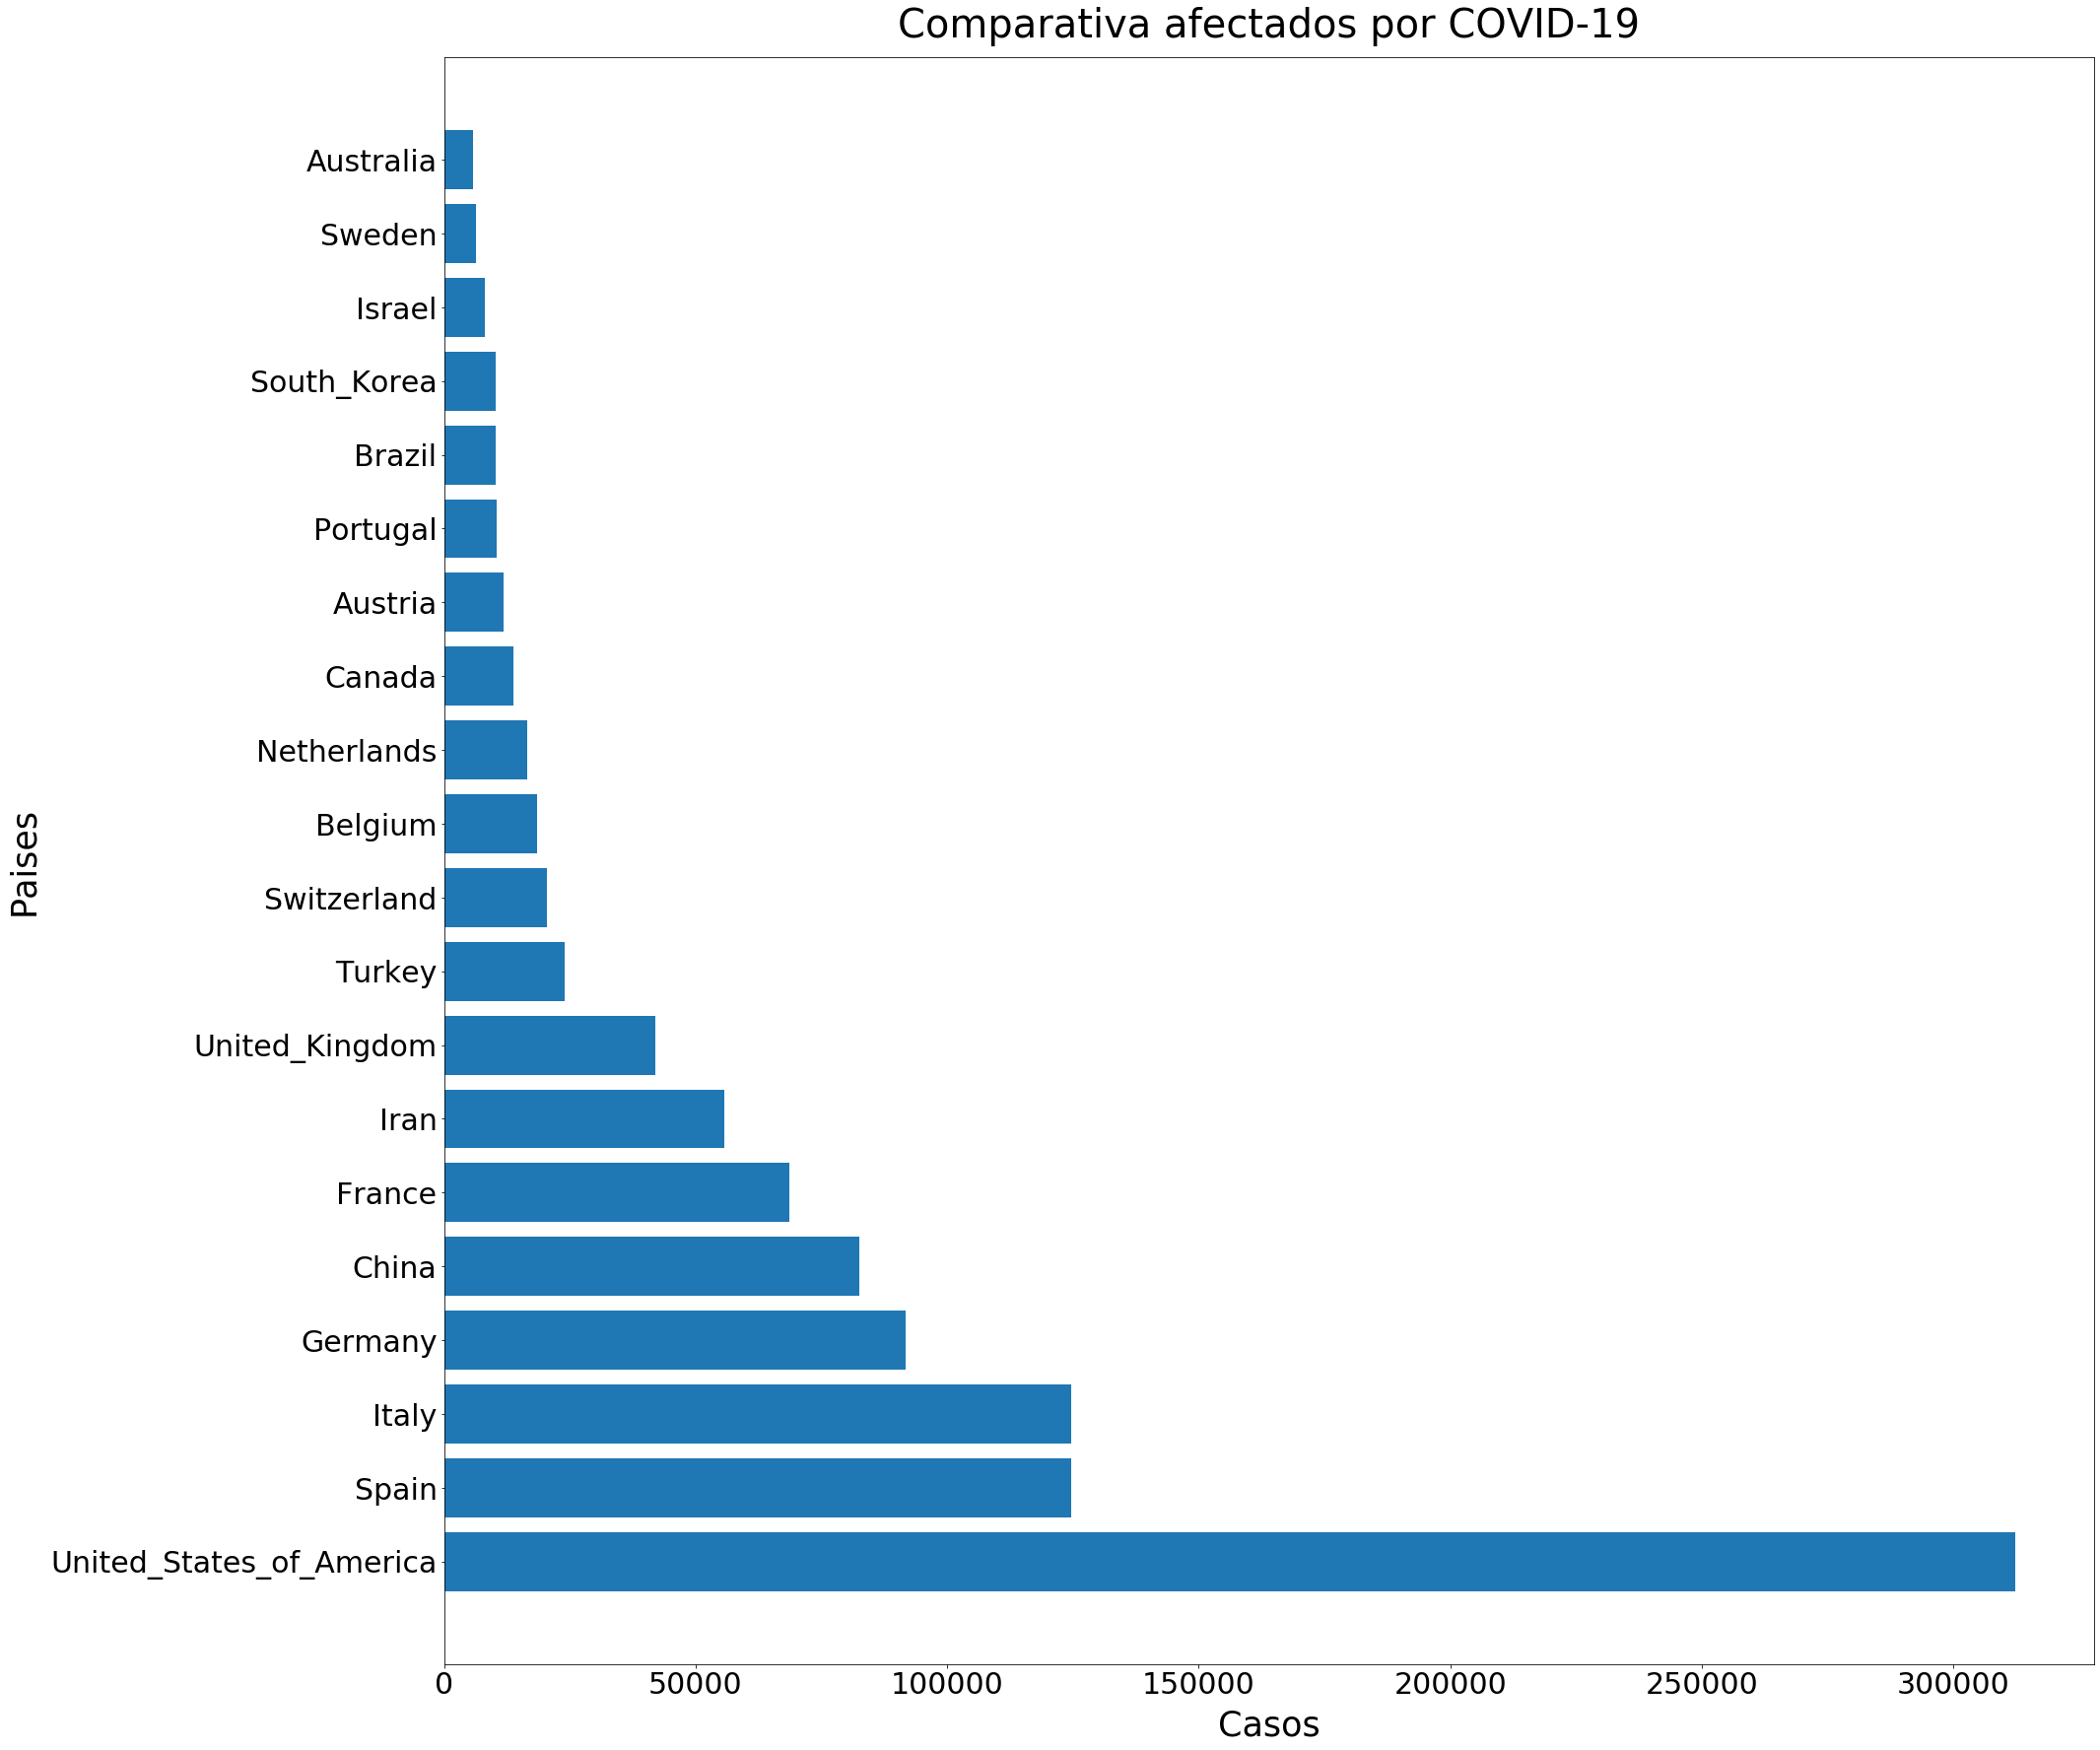

In [370]:
plt.subplots(figsize=(30,30))

plt.barh(acumuladosPais['countriesAndTerritories'], acumuladosPais['cases'])

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Casos", fontsize=35, labelpad=10)
plt.ylabel("Paises", fontsize=35, labelpad=10)
plt.title("Comparativa afectados por COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("ComparativaPaises.jpg", bbox_inches = "tight")

plt.show()

In [371]:
acumuladosPais['%cases'] = (acumuladosPais['cases']/acumuladosPais['popData2018'])*100
acumuladosPais = acumuladosPais.sort_values(by=['%cases'], ascending=False).head(20)
acumuladosPais.head(5)

,countriesAndTerritories,geoId,popData2018,cases,deaths,%cases
171,Spain,ES,46723749.0,124736,11744,0.266965
176,Switzerland,CH,8516543.0,20489,666,0.240579
94,Italy,IT,60431283.0,124632,15362,0.206238
17,Belgium,BE,11422068.0,18431,1283,0.161363
10,Austria,AT,8847037.0,11766,186,0.132994


## Porcentaje casos totales acumulados COVID-19

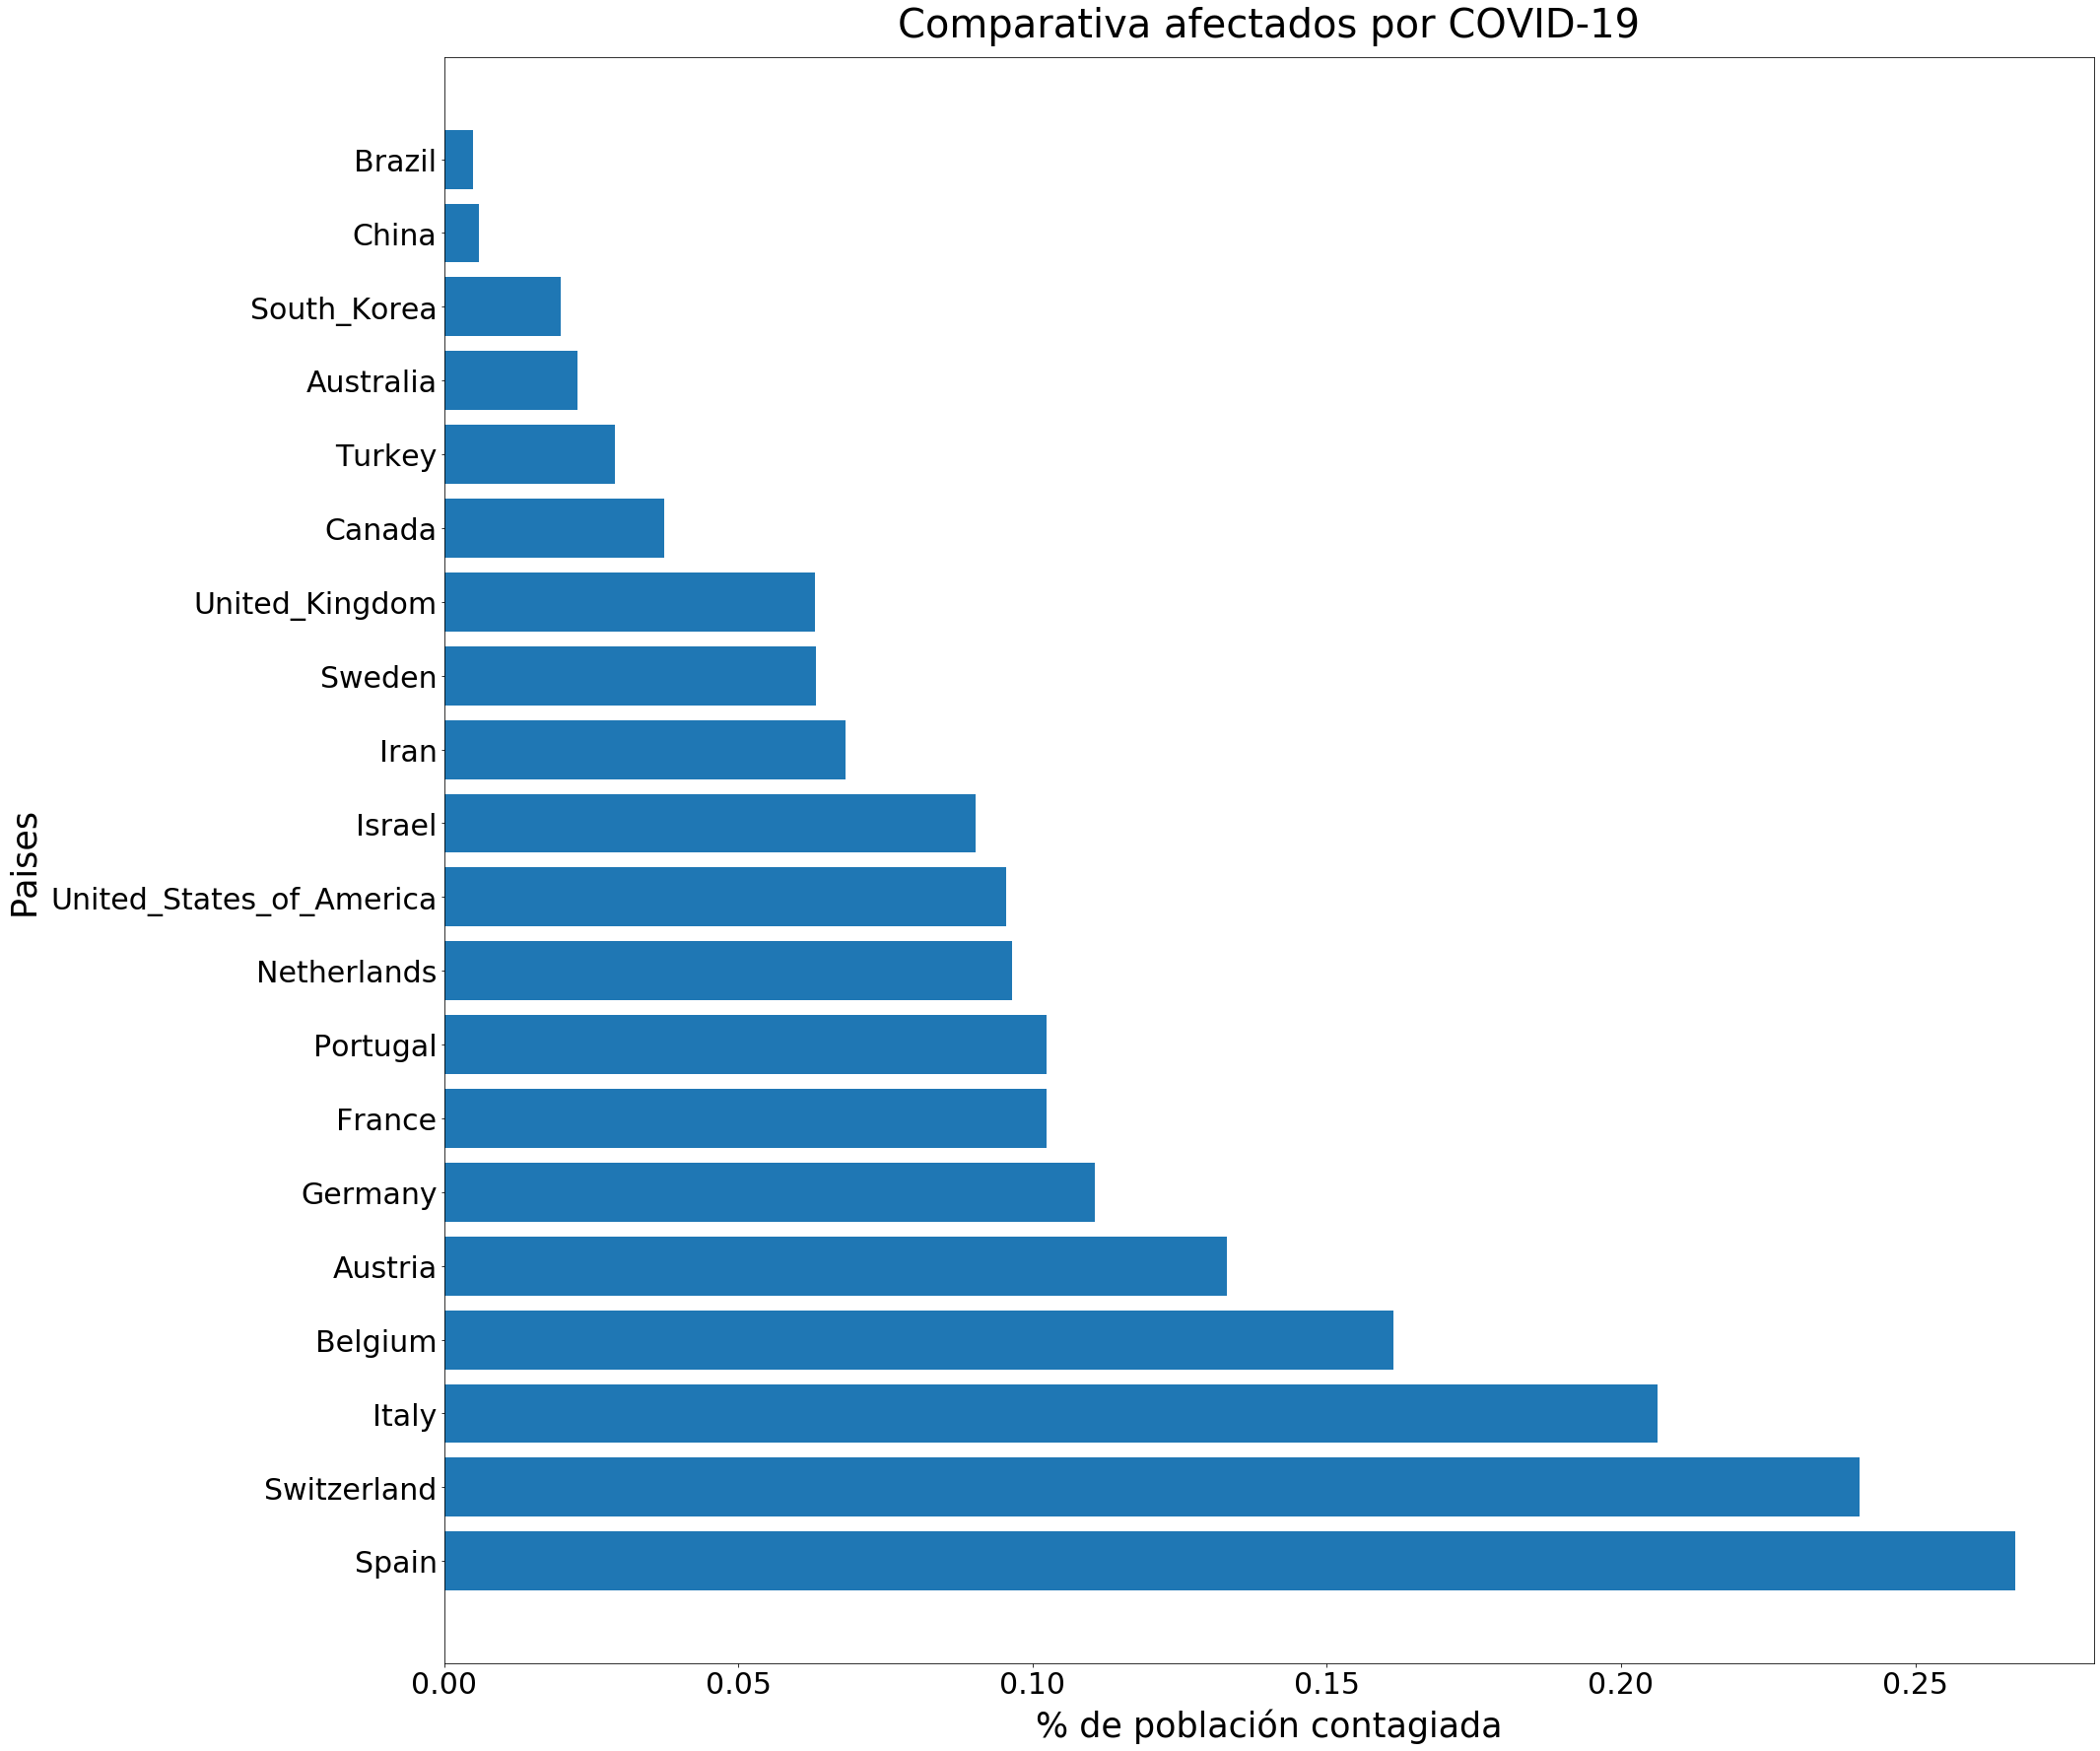

In [372]:
plt.subplots(figsize=(30,30))

plt.barh(acumuladosPais['countriesAndTerritories'], acumuladosPais['%cases'])

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("% de población contagiada", fontsize=35, labelpad=10)
plt.ylabel("Paises", fontsize=35, labelpad=10)
plt.title("Comparativa afectados por COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("ComparativaPaises%casos.jpg", bbox_inches = "tight")

plt.show()

## Comparativa paises casos diarios COVID-19

In [373]:
US = data[(data['countriesAndTerritories'] == 'United_States_of_America') & (data['dateRep'] > '15/01/2020')]
IT = data[(data['countriesAndTerritories'] == 'Italy') & (data['dateRep'] > '15/01/2020')]
ES = data[(data['countriesAndTerritories'] == 'Spain') & (data['dateRep'] > '15/01/2020')]
CN = data[(data['countriesAndTerritories'] == 'China') & (data['dateRep'] > '15/01/2020')]
DE = data[(data['countriesAndTerritories'] == 'Germany') & (data['dateRep'] > '15/01/2020')]
FR = data[(data['countriesAndTerritories'] == 'France') & (data['dateRep'] > '15/01/2020')]
IR = data[(data['countriesAndTerritories'] == 'Iran') & (data['dateRep'] > '15/01/2020')]
UK = data[(data['countriesAndTerritories'] == 'United_Kingdom') & (data['dateRep'] > '15/01/2020')]

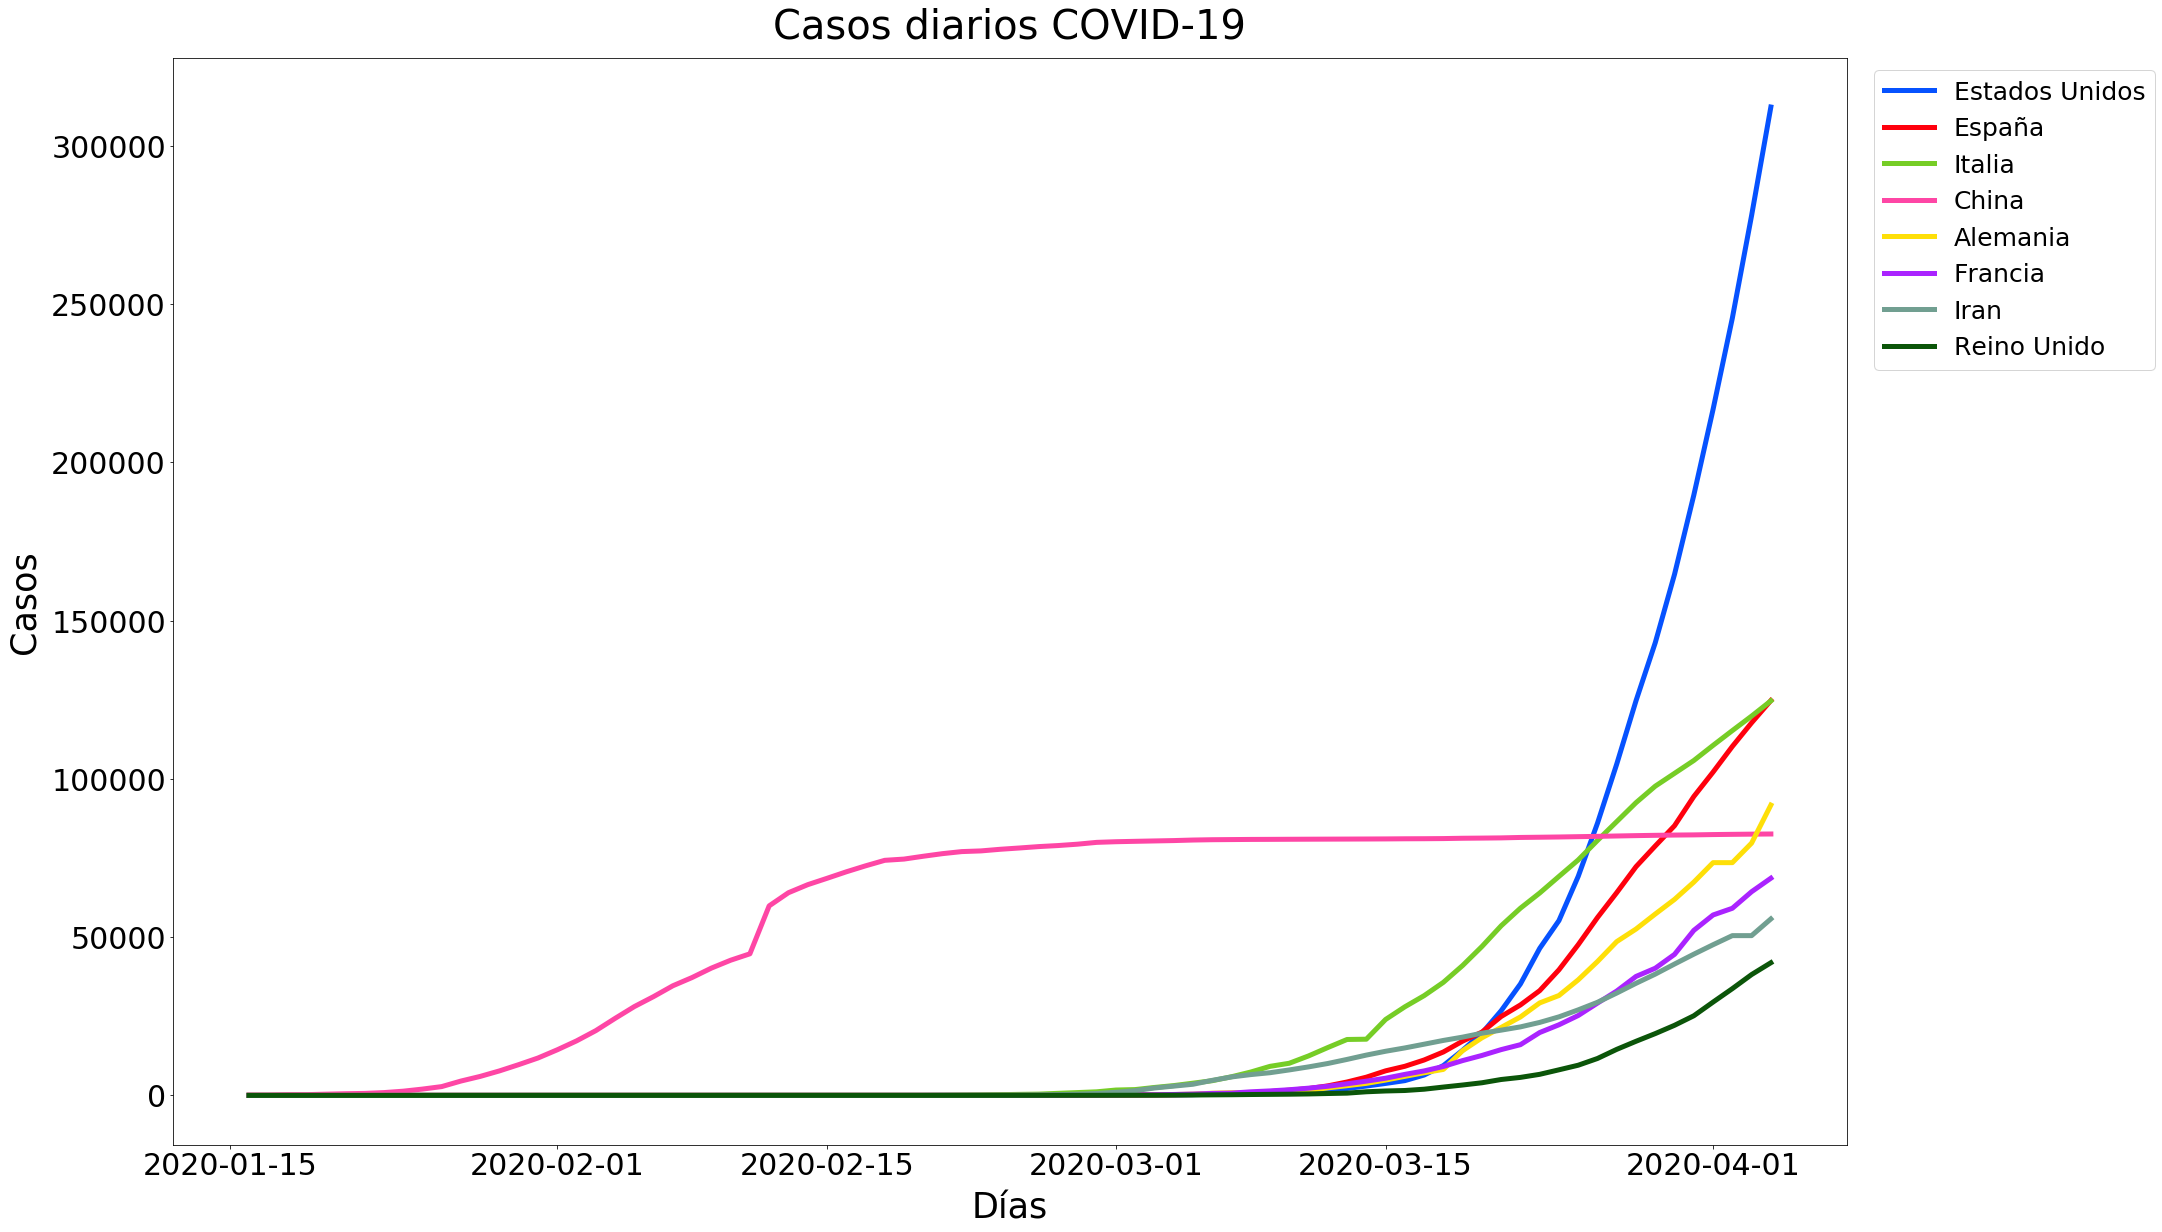

In [374]:
ax = plt.subplots(figsize=(30,20))

plt.plot(US['dateRep'], US['casesacum'], label = 'Estados Unidos', linewidth=5, color = 'xkcd:electric blue')
plt.plot(ES['dateRep'], ES['casesacum'], label = 'España', linewidth=5, color = 'xkcd:bright red')
plt.plot(IT['dateRep'], IT['casesacum'], label = 'Italia', linewidth=5, color = 'xkcd:apple green')
plt.plot(CN['dateRep'], CN['casesacum'], label = 'China', linewidth=5, color = 'xkcd:barbie pink') 
plt.plot(DE['dateRep'], DE['casesacum'], label = 'Alemania', linewidth=5, color = 'xkcd:dandelion') 
plt.plot(FR['dateRep'], FR['casesacum'], label = 'Francia', linewidth=5, color = 'xkcd:electric purple')
plt.plot(IR['dateRep'], IR['casesacum'], label = 'Iran', linewidth=5, color = 'xkcd:greyish teal')
plt.plot(UK['dateRep'], UK['casesacum'], label = 'Reino Unido', linewidth=5, color = 'xkcd:forest')
                
plt.legend(loc='upper left')

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')

plt.legend(prop = {'size':25}, loc = 'upper center', bbox_to_anchor=(1.1, 1))
    
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos", fontsize=35, labelpad=10)
plt.title("Casos diarios COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiarios.jpg", bbox_inches = "tight")
plt.show()

## Comparativa paises casos diarios COVID-19 contabilizando desde el contagiado 50

In [375]:
US = data[(data['countriesAndTerritories'] == 'United_States_of_America') & (data['day_0'] > 0) & (data['day_0'] < 60)]
IT = data[(data['countriesAndTerritories'] == 'Italy') & (data['day_0'] > 0) & (data['day_0'] < 60)]
ES = data[(data['countriesAndTerritories'] == 'Spain') & (data['day_0'] > 0) & (data['day_0'] < 60)]
CN = data[(data['countriesAndTerritories'] == 'China') & (data['day_0'] > 0) & (data['day_0'] < 60)]
DE = data[(data['countriesAndTerritories'] == 'Germany') & (data['day_0'] > 0) & (data['day_0'] < 60)]
FR = data[(data['countriesAndTerritories'] == 'France') & (data['day_0'] > 0) & (data['day_0'] < 60)]
IR = data[(data['countriesAndTerritories'] == 'Iran') & (data['day_0'] > 0) & (data['day_0'] < 60)]
UK = data[(data['countriesAndTerritories'] == 'United_Kingdom') & (data['day_0'] > 0) & (data['day_0'] < 60)]

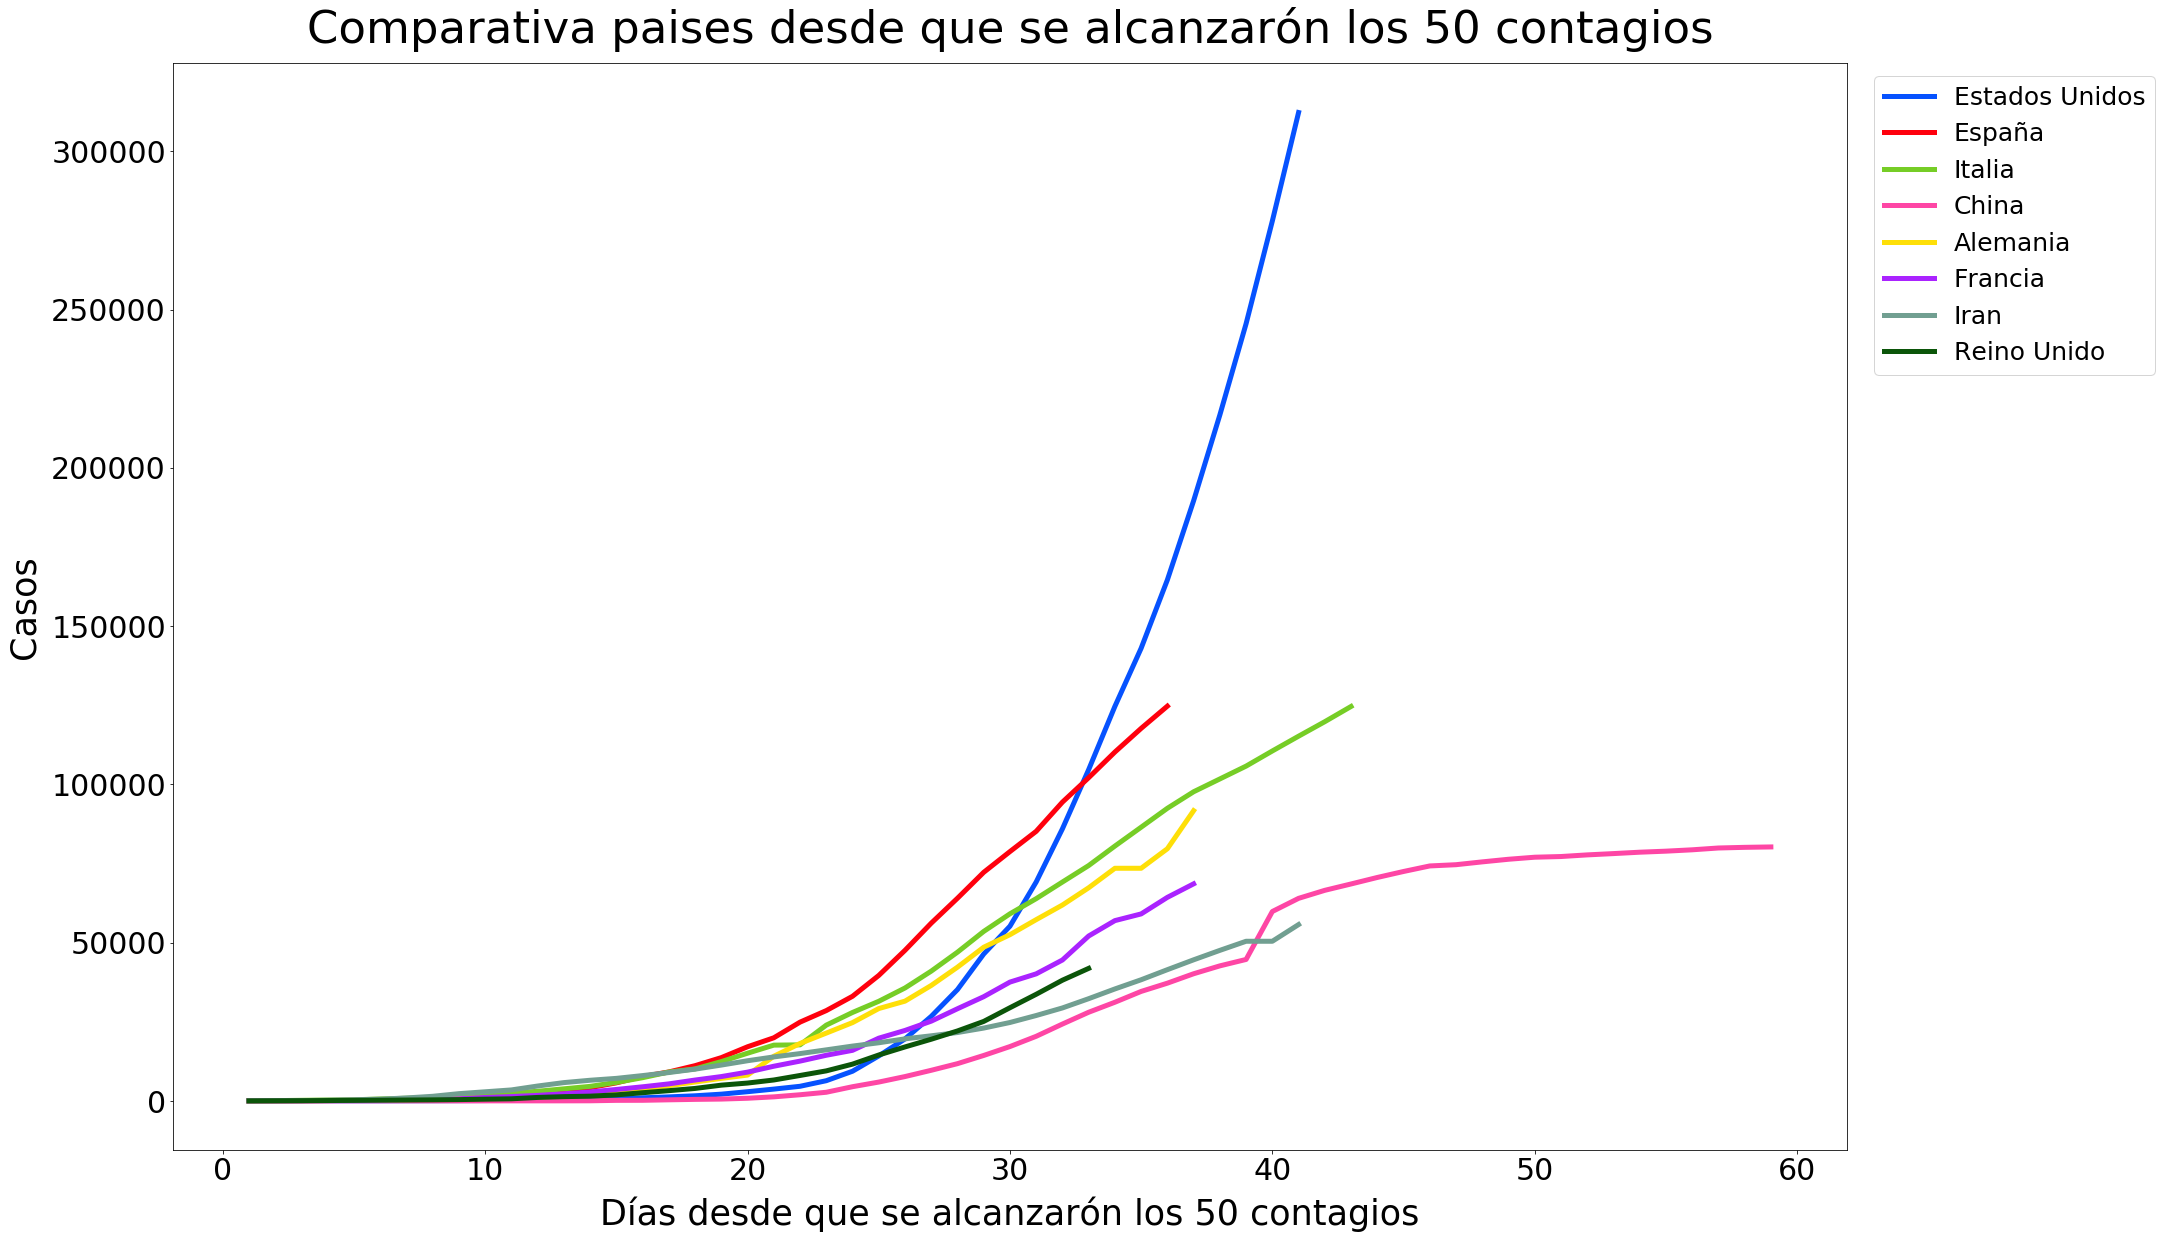

In [376]:
ax = plt.subplots(figsize=(30,20))

plt.plot(US['day_0'], US['casesacum'], label = 'Estados Unidos', linewidth=5, color = 'xkcd:electric blue')
plt.plot(ES['day_0'], ES['casesacum'], label = 'España', linewidth=5, color = 'xkcd:bright red')
plt.plot(IT['day_0'], IT['casesacum'], label = 'Italia', linewidth=5, color = 'xkcd:apple green')
plt.plot(CN['day_0'], CN['casesacum'], label = 'China', linewidth=5, color = 'xkcd:barbie pink') 
plt.plot(DE['day_0'], DE['casesacum'], label = 'Alemania', linewidth=5, color = 'xkcd:dandelion') 
plt.plot(FR['day_0'], FR['casesacum'], label = 'Francia', linewidth=5, color = 'xkcd:electric purple')
plt.plot(IR['day_0'], IR['casesacum'], label = 'Iran', linewidth=5, color = 'xkcd:greyish teal')
plt.plot(UK['day_0'], UK['casesacum'], label = 'Reino Unido', linewidth=5, color = 'xkcd:forest')
                
plt.legend(loc='upper left')

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')

plt.legend(prop = {'size':25}, loc = 'upper center', bbox_to_anchor=(1.1, 1))
    
plt.xlabel("Días desde que se alcanzarón los 50 contagios", fontsize=35, labelpad=10)
plt.ylabel("Casos", fontsize=35, labelpad=10)
plt.title("Comparativa paises desde que se alcanzarón los 50 contagios", fontsize=45, loc='center', pad=20)
plt.savefig("ComparativaPaisesDesde50Contagios", bbox_inches = "tight")
plt.show()

## Comparativa paises casos diarios COVID-19 contabilizando desde el contagiado 50

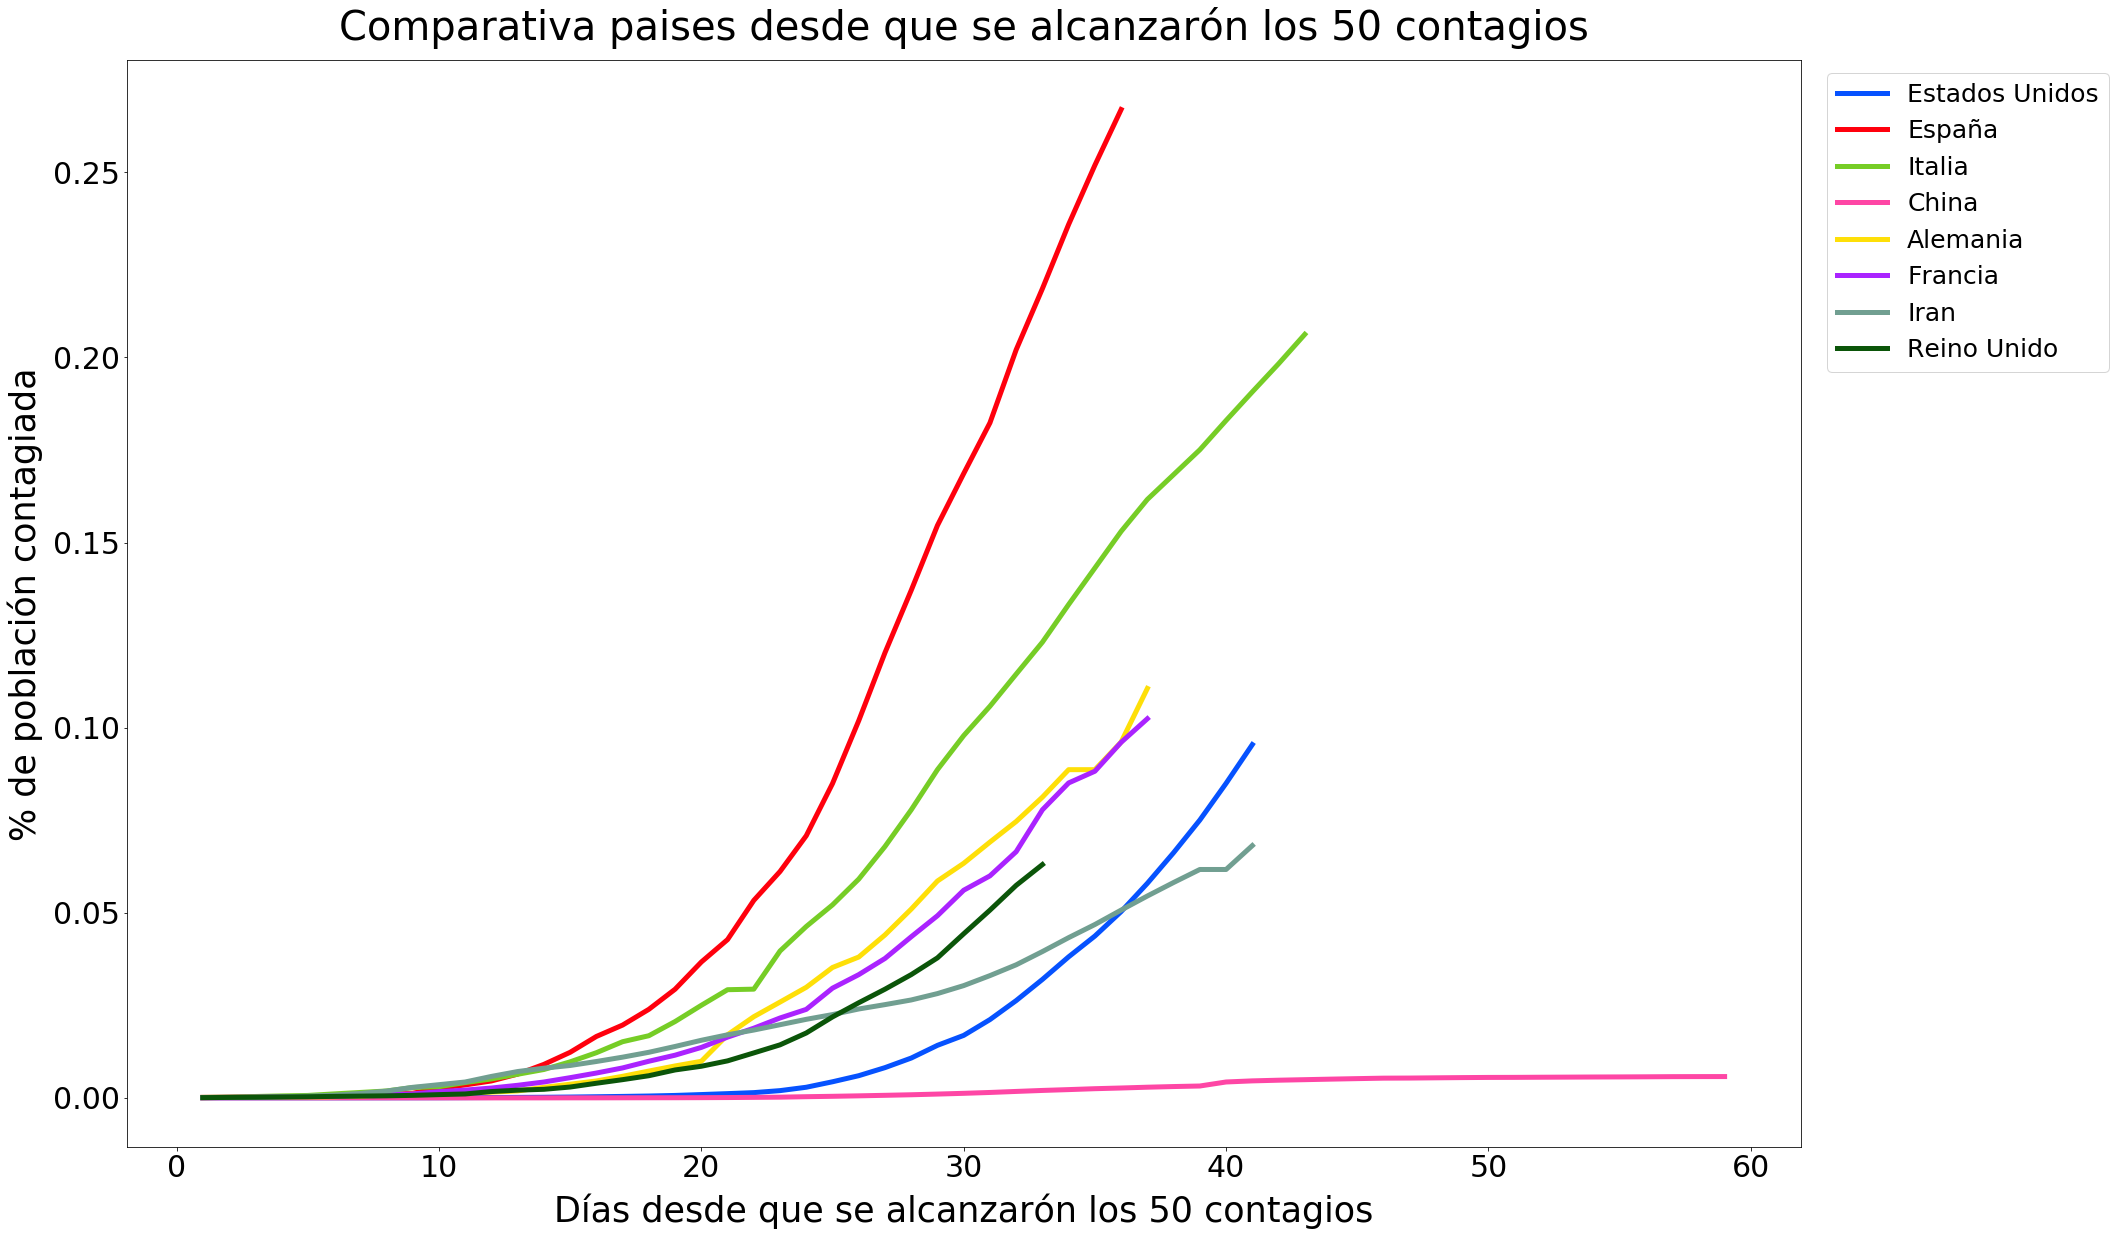

In [377]:
ax = plt.subplots(figsize=(30,20))

plt.plot(US['day_0'], US['%cases'], label = 'Estados Unidos', linewidth=5, color = 'xkcd:electric blue')
plt.plot(ES['day_0'], ES['%cases'], label = 'España', linewidth=5, color = 'xkcd:bright red')
plt.plot(IT['day_0'], IT['%cases'], label = 'Italia', linewidth=5, color = 'xkcd:apple green')
plt.plot(CN['day_0'], CN['%cases'], label = 'China', linewidth=5, color = 'xkcd:barbie pink') 
plt.plot(DE['day_0'], DE['%cases'], label = 'Alemania', linewidth=5, color = 'xkcd:dandelion') 
plt.plot(FR['day_0'], FR['%cases'], label = 'Francia', linewidth=5, color = 'xkcd:electric purple')
plt.plot(IR['day_0'], IR['%cases'], label = 'Iran', linewidth=5, color = 'xkcd:greyish teal')
plt.plot(UK['day_0'], UK['%cases'], label = 'Reino Unido', linewidth=5, color = 'xkcd:forest')
                
plt.legend(loc='upper left')

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')

plt.legend(prop = {'size':25}, loc = 'upper center', bbox_to_anchor=(1.1, 1))
    
plt.xlabel("Días desde que se alcanzarón los 50 contagios", fontsize=35, labelpad=10)
plt.ylabel("% de población contagiada", fontsize=35, labelpad=10)
plt.title("Comparativa paises desde que se alcanzarón los 50 contagios", fontsize=40, loc='center', pad=20)
plt.savefig("Comparativa%Desde50Contagios", bbox_inches = "tight")
plt.show()

# Estados Unidos

## Casos diarios

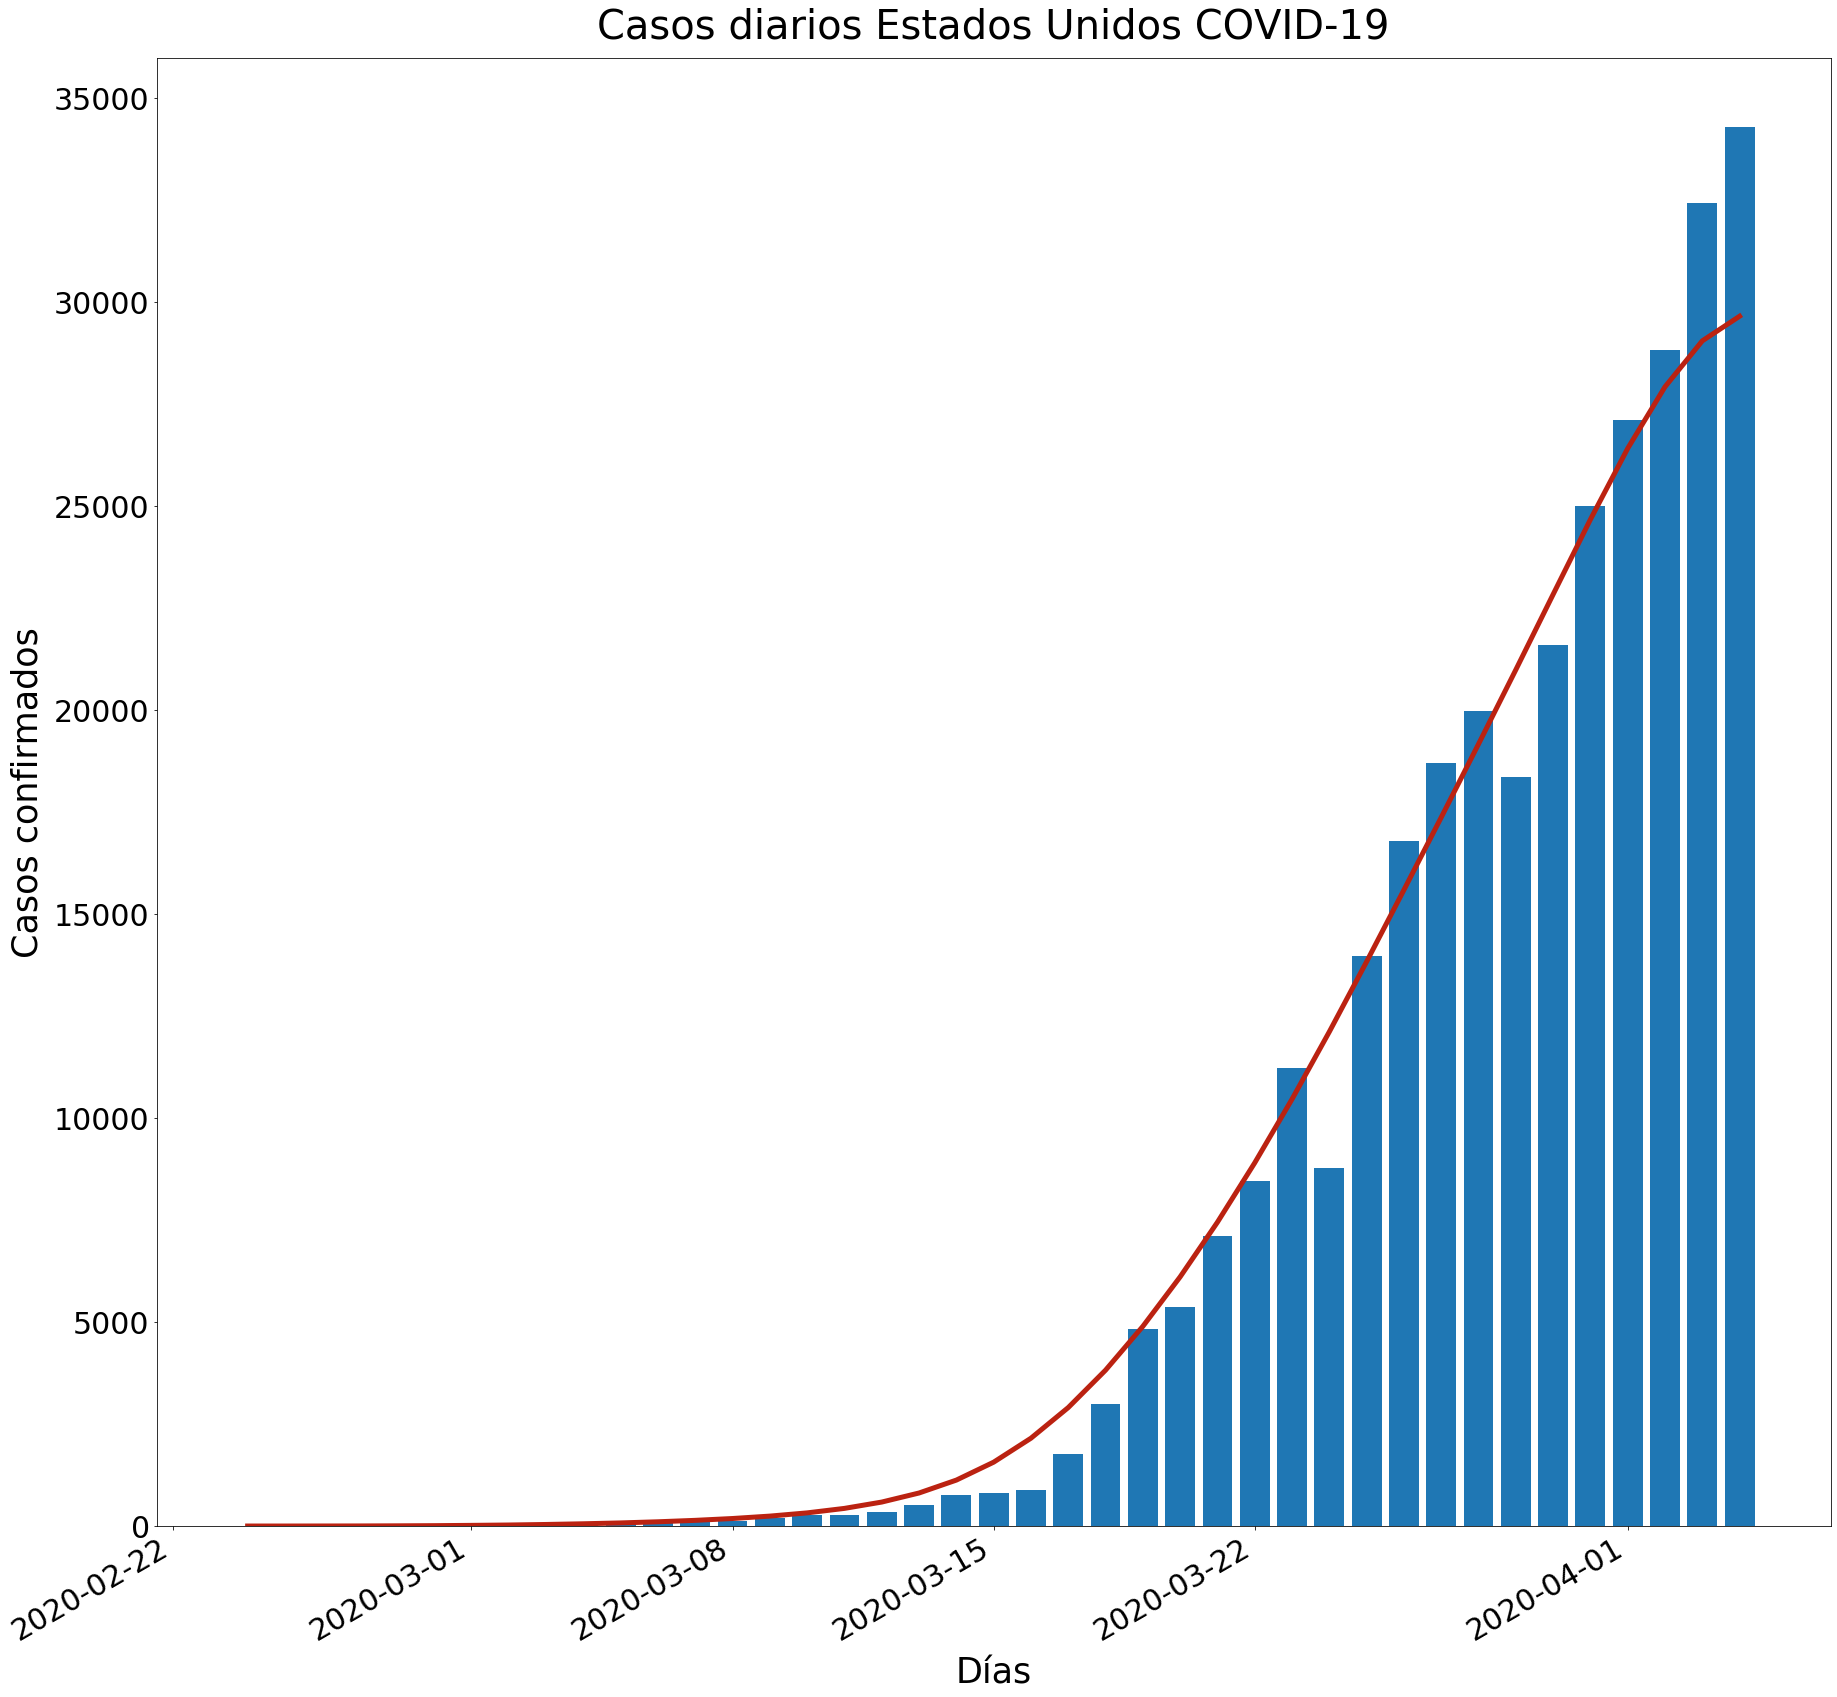

In [378]:
fig, ax =plt.subplots(figsize=(30,30))

plt.bar(US['dateRep'], US['cases'])
plt.plot(US['dateRep'], gaussian_filter1d(US['cases'], sigma=3),linewidth=5, color = '#BB2211')

fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos confirmados", fontsize=35, labelpad=10)
plt.title("Casos diarios Estados Unidos COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiariosUS.jpg", bbox_inches = "tight")

plt.show()

# España

## Casos diarios

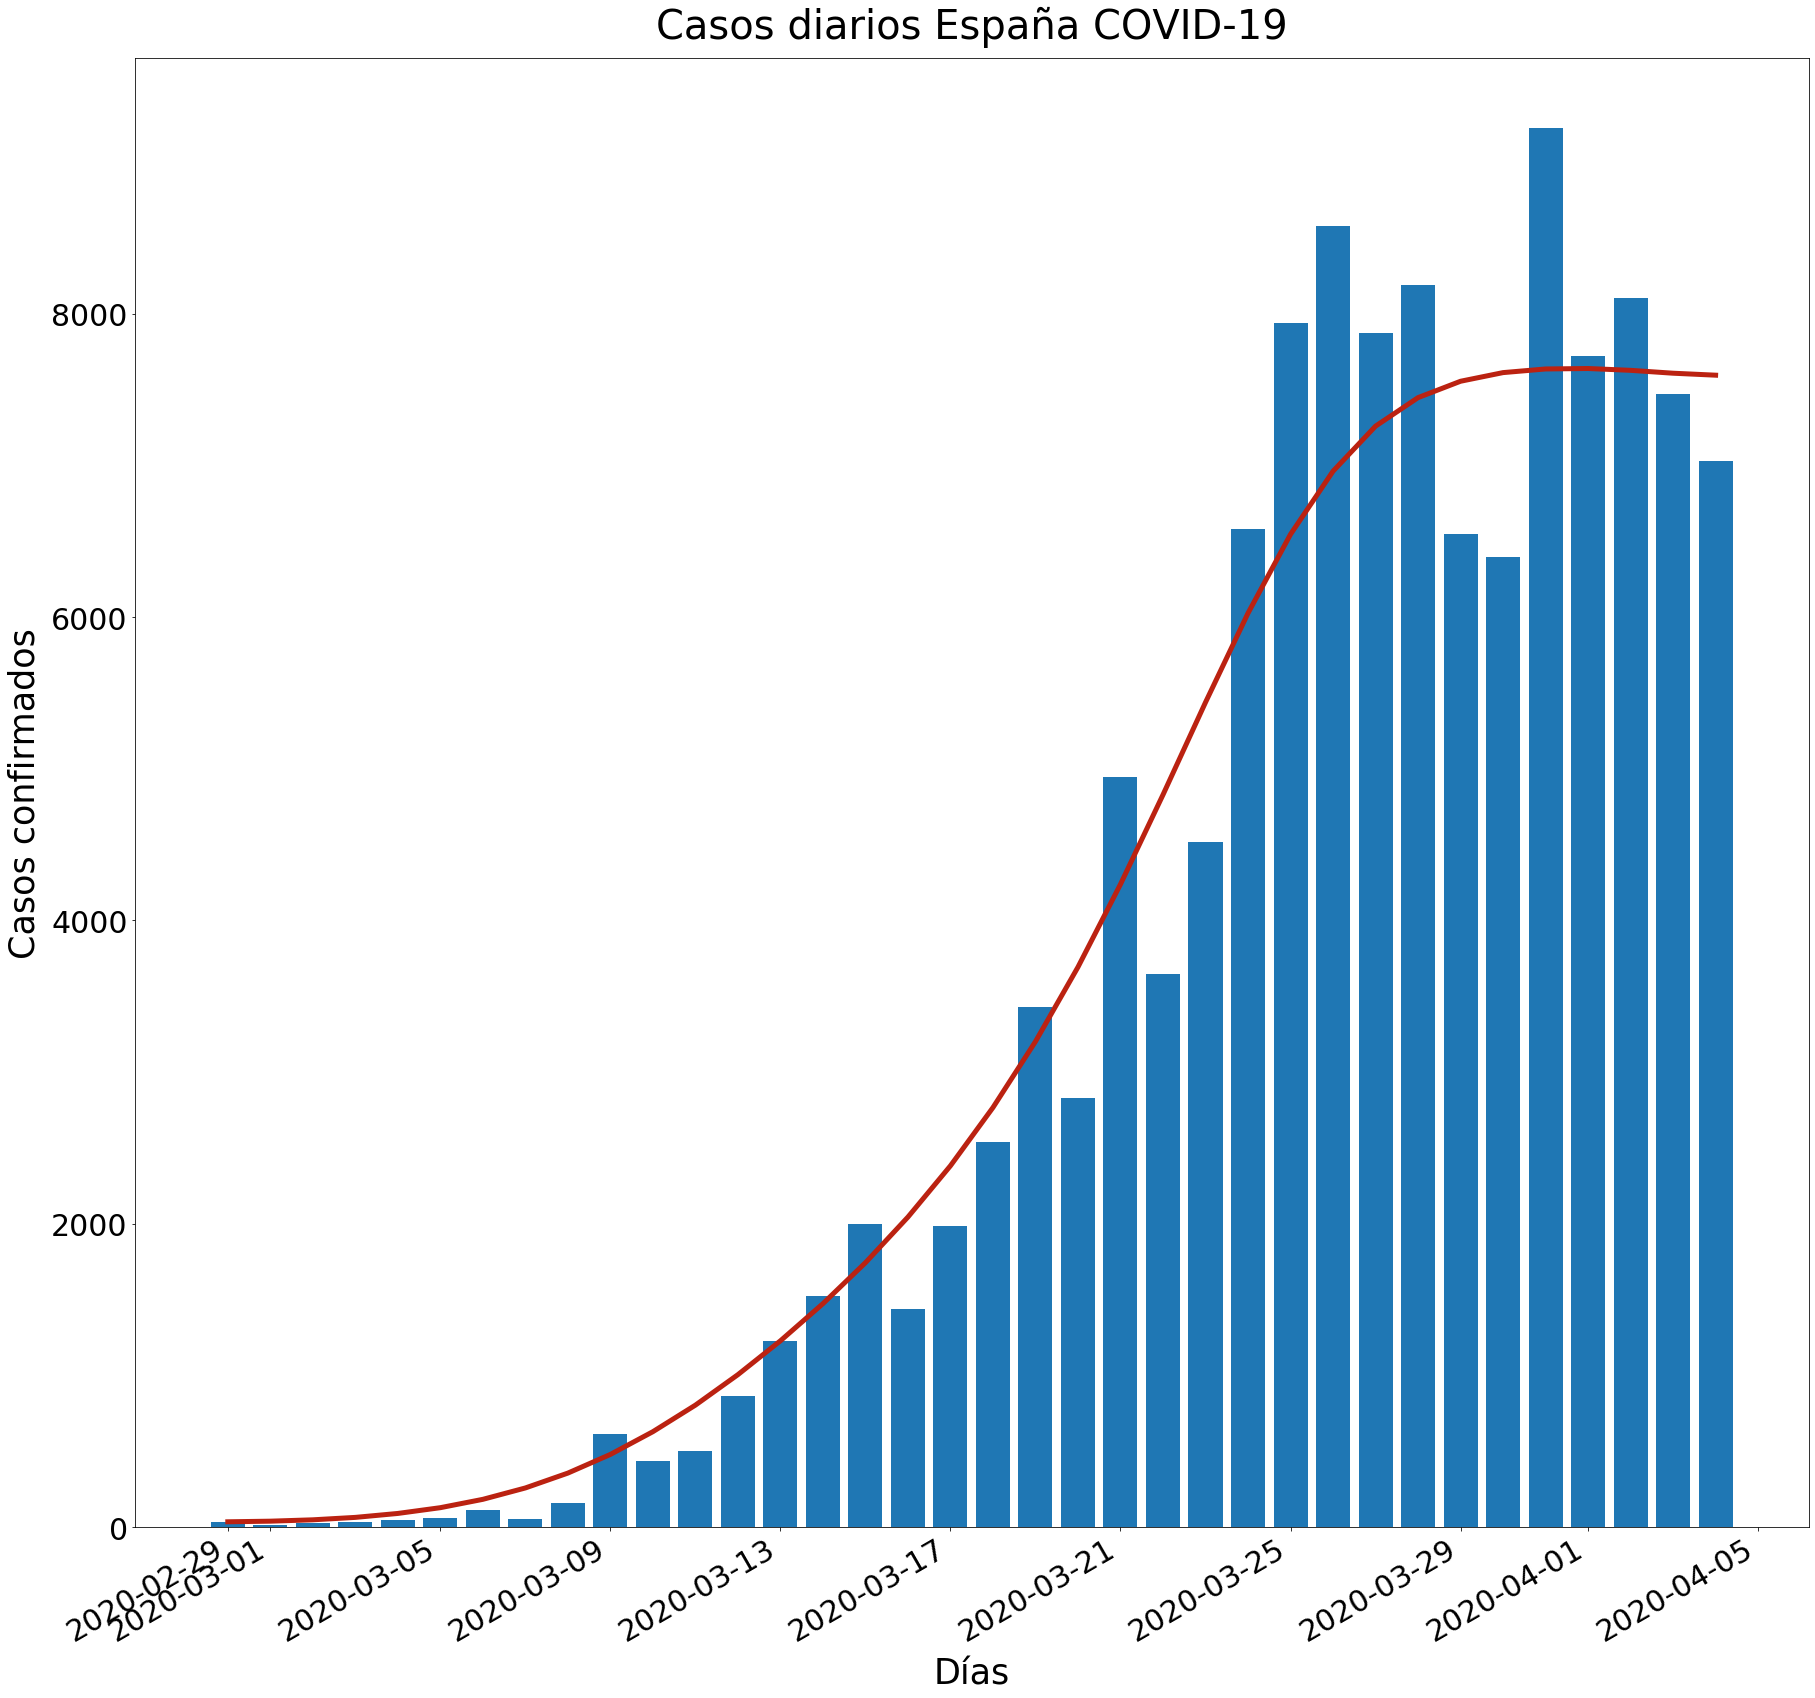

In [379]:
fig, ax =plt.subplots(figsize=(30,30))

plt.bar(ES['dateRep'], ES['cases'])
plt.plot(ES['dateRep'], gaussian_filter1d(ES['cases'], sigma=3),linewidth=5, color = '#BB2211')

fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos confirmados", fontsize=35, labelpad=10)
plt.title("Casos diarios España COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiariosES.jpg", bbox_inches = "tight")

plt.show()

# Italia

## Casos diarios

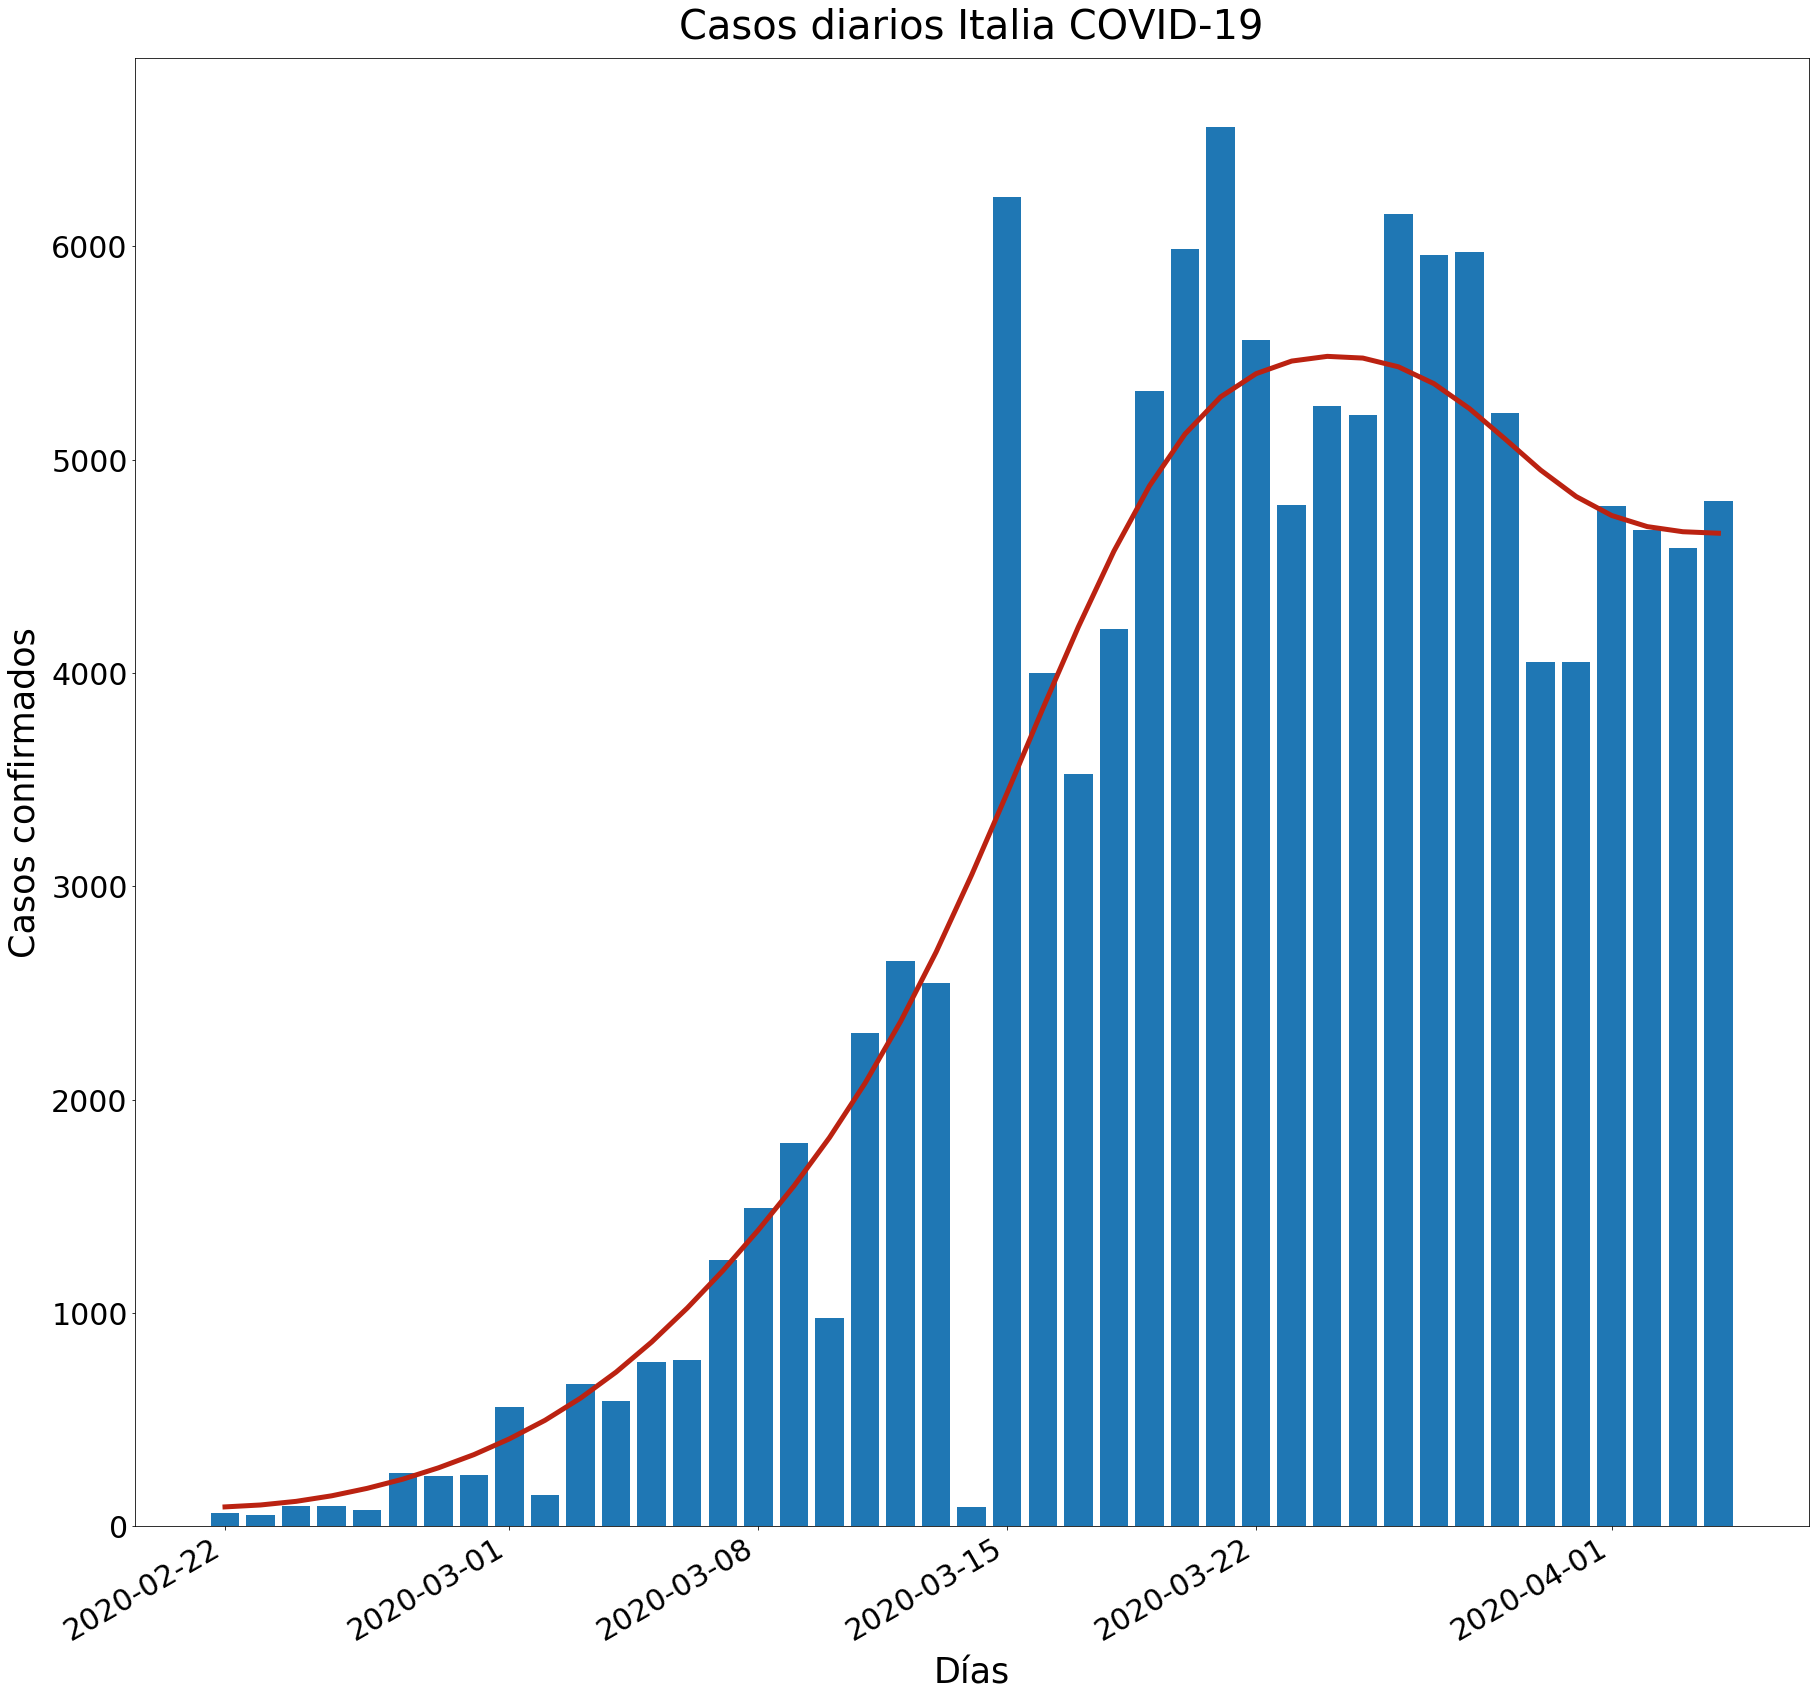

In [380]:
fig, ax =plt.subplots(figsize=(30,30))

plt.bar(IT['dateRep'], IT['cases'])
plt.plot(IT['dateRep'], gaussian_filter1d(IT['cases'], sigma=3),linewidth=5, color = '#BB2211')

fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos confirmados", fontsize=35, labelpad=10)
plt.title("Casos diarios Italia COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiariosIT.jpg", bbox_inches = "tight")

plt.show()

# Mundial

In [381]:
acumulados = data.groupby(['dateRep']).agg({'cases':'sum', 'deaths':'sum'}).reset_index()

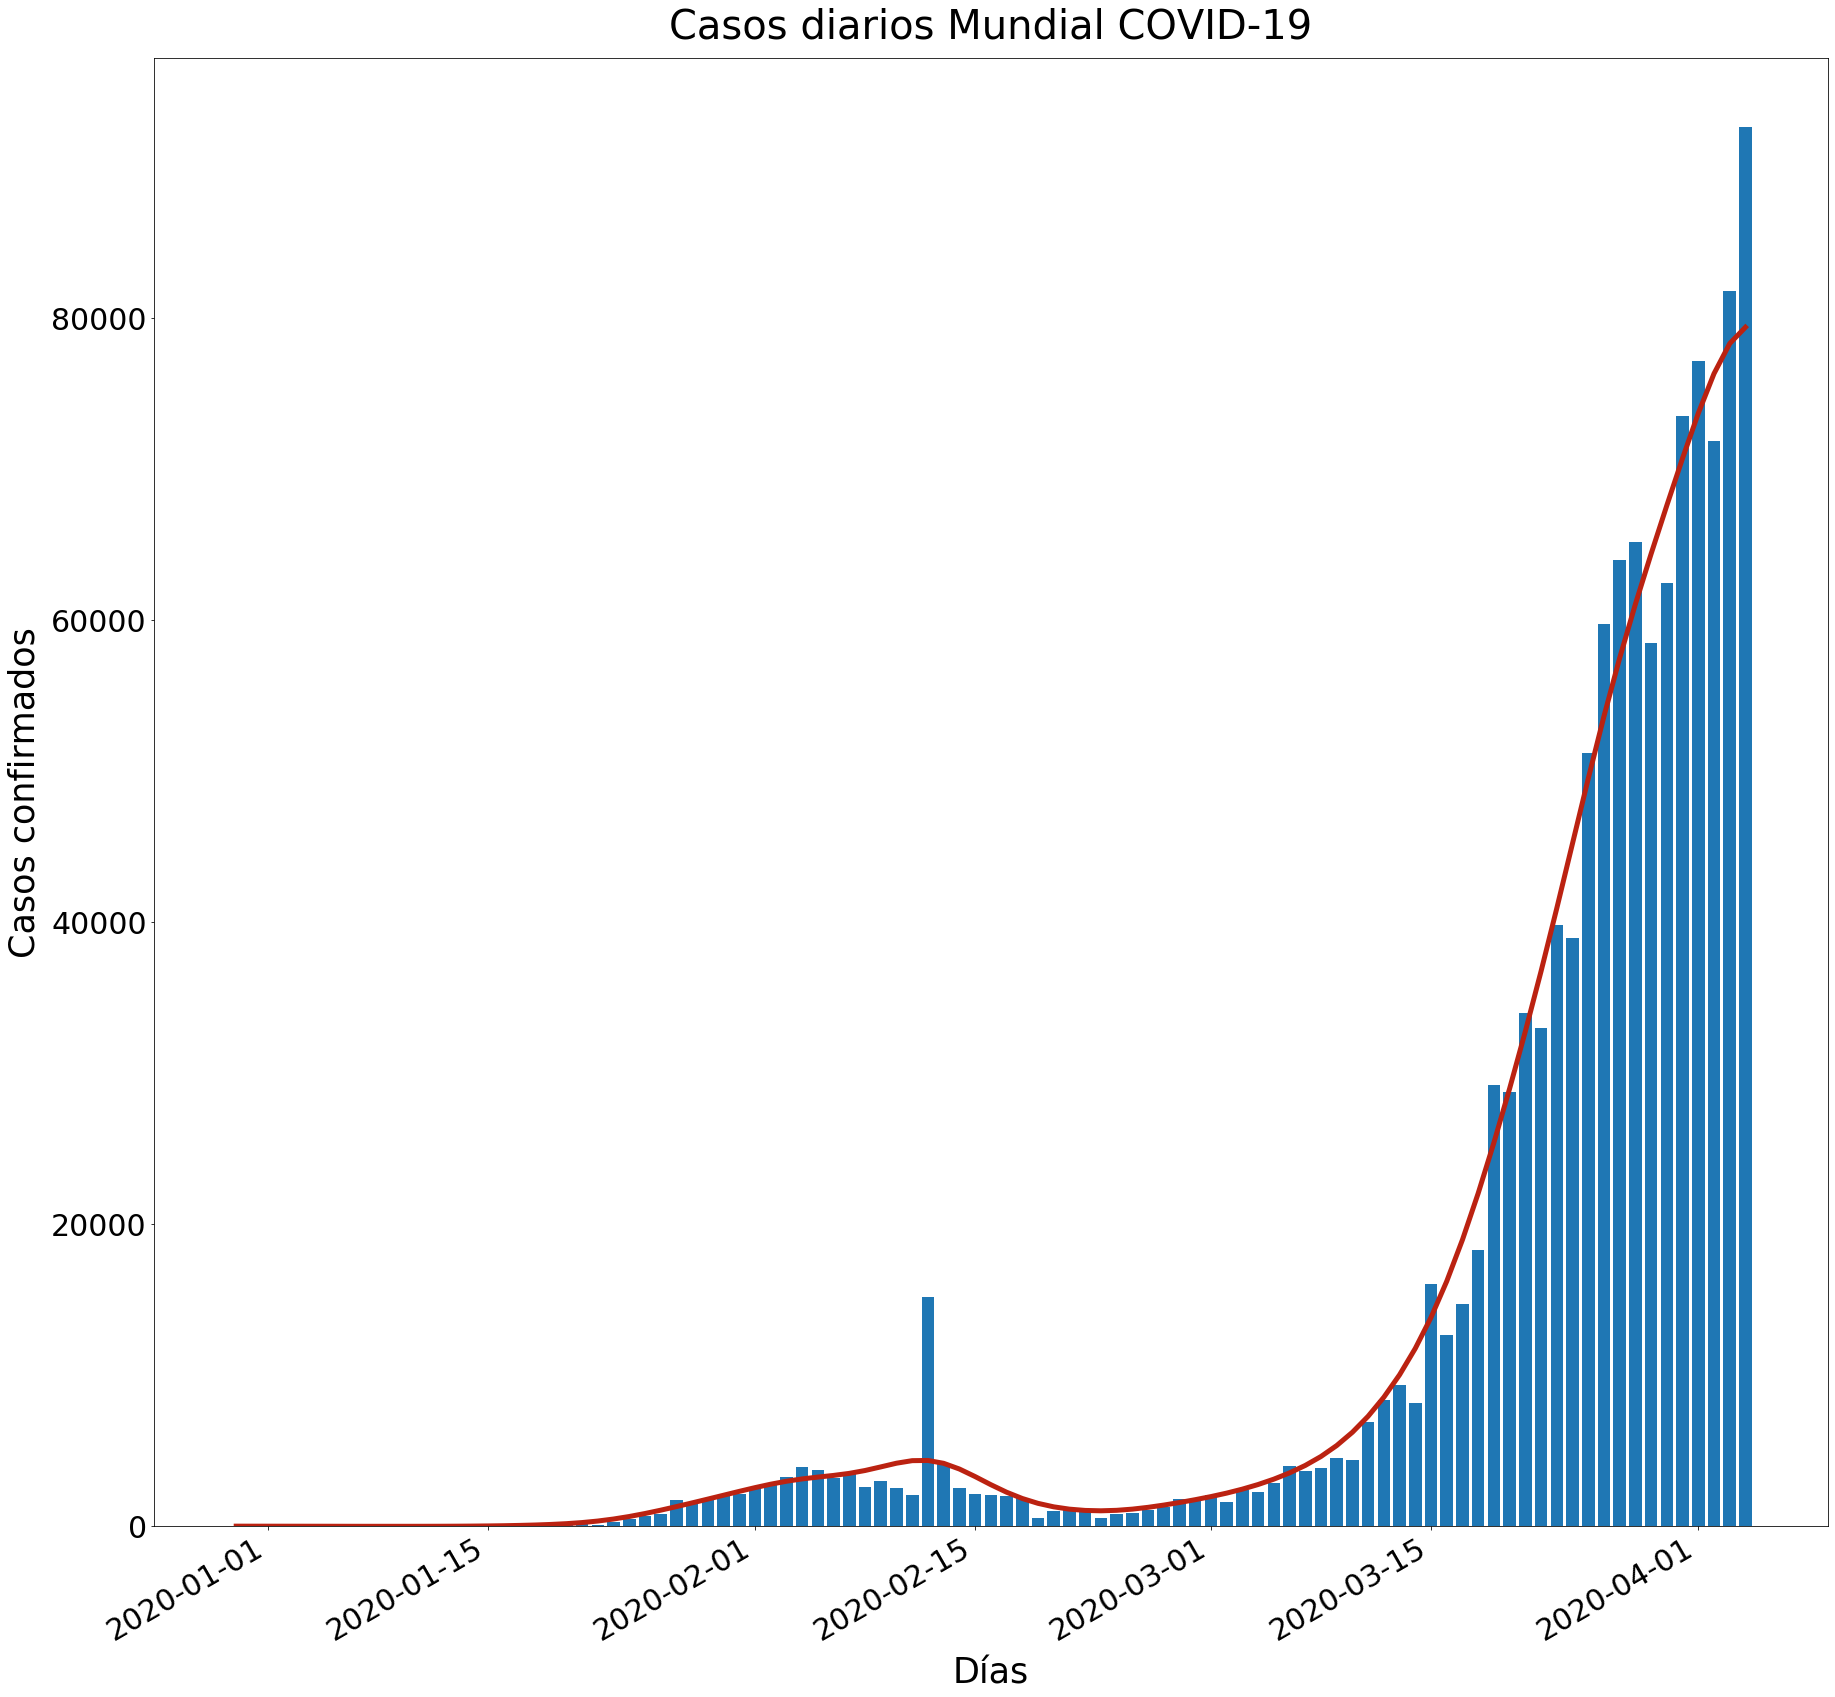

In [382]:
fig, ax =plt.subplots(figsize=(30,30))

plt.bar(acumulados['dateRep'], acumulados['cases'])
plt.plot(acumulados['dateRep'], gaussian_filter1d(acumulados['cases'], sigma=3),linewidth=5, color = '#BB2211')

fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos confirmados", fontsize=35, labelpad=10)
plt.title("Casos diarios Mundial COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiariosMundial.jpg", bbox_inches = "tight")

plt.show()